# Master M2 MVA 2021/2022 - Convex Optimization, Algorithms and Applications - Homework 3
**Author: Hugo SIMON**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. LASSO and its dual problem

The LASSO problem rewrittes
\begin{aligned}
\min_w \frac 1 2 \lVert X w - y \rVert^2_2 + \lambda \lVert w \rVert_1 =& \min_{w,z} \frac 1 2 \lVert z \rVert^2_2 + \lambda \lVert w \rVert_1 \\
& z = Xw - y
\end{aligned}
The Lagrangian is given by
$$ \mathcal L (w,z,v) = \frac 1 2 \lVert z \rVert^2_2 + \lambda \lVert w \rVert_1 + v^\top (Xw-y-z)$$
Then the dual function is
\begin{aligned}
\inf_{w,z} \mathcal L(w,z,v) &= \inf_{z} \frac 1 2 \lVert z \rVert^2_2 - z^\top v  + \inf_{w} \lambda \lVert w \rVert_1 - w^\top (-X^\top v) - v^\top y \quad\quad \text{(separability)}\\
&= -\sup_{z} \left( z^\top v  - \frac 1 2 \lVert z \rVert^2_2 \right) - \lambda \sup_{w} \left( w^\top (- \frac 1 \lambda X^\top v) - \lVert w \rVert_1 \right) - v^\top y \\ 
 \text{(first term maximized for }& z = v \text{ , second term maximized depending only on sign and finitness of }w)\\
&= - \left( \frac 1 2 \lVert \cdot \rVert^2_2 \right)^* (v) - \lambda \left( \lVert \cdot \rVert_1 \right)^* (- \frac 1 \lambda X^\top v) - v^\top y \\
&= - \frac 1 2 \lVert v \rVert^2_2 - v^\top y - \iota_{\{ -1 \preceq - \frac 1 \lambda X^\top v \preceq 1\}}
\end{aligned}
Thereby the dual problem is

\begin{matrix}
\max_{v} - \frac 1 2 \lVert v \rVert^2_2 - v^\top y &= - \min_{v} \frac 1 2 \lVert v \rVert^2_2 + v^\top y &= - \min_{v} v^\top Q v + v^\top p\\
\lVert X^\top v \rVert_\infty \leq \lambda & \lVert X^\top v \rVert_\infty \leq \lambda  & Av \preceq b \\
&&\text{with } Q = \frac 1 2 I \ , \ p = y \\
&&A = \begin{pmatrix}X^\top \\ -X^\top\end{pmatrix} \ , \ b = \lambda \bf 1
\end{matrix}

In [2]:
def primal(w, X, y, λ):
    return np.linalg.norm(X @ w - y, 2)**2 / 2 + λ * np.linalg.norm(w, 1)

def dual(v, Q, p):
    return (v @ Q * v).sum(axis=-1) + v @ p

def objective(v, Q, p, A, b, t):
    if np.any(b <= A @ v.T):
        return np.inf
    return t * dual(v, Q , p) - np.log(b - A @ v).sum()

def gradient(v, Q, p, A, b, t):
    return t * (2 * Q @ v + p) + A.T @ (b - A @ v)**(-1)

def hessian(v, Q, p, A, b, t):
    return t * 2 * Q + (A.T * (b - A @ v)**(-2)) @ A

# 2. Implementing the barrier method to solve QP

In [3]:
def backtracking_line_search(f, v, dv, grad_f_v, α=.5, β=.9):
    step_size = 1

    while f(v + step_size * dv) > f(v) + α * step_size * grad_f_v.T @ dv:
        step_size *= β
    return step_size



def centering_step(Q, p, A, b, t, v0, eps, nb_max_iter=20):
    
    obj = lambda v: objective(v, Q, p, A, b, t)
    grad = lambda v: gradient(v, Q, p, A, b, t)
    hess = lambda v: hessian(v, Q, p, A, b, t)

    v = v0
    v_list = [v]
    stopping_criterion = np.inf
    
    # Newton's method
    for iteration in range(nb_max_iter):
        grad_v = grad(v)
        L_inv = np.linalg.inv(np.linalg.cholesky(hess(v)))
        L_inv_grad = L_inv @ grad_v
        dv = - L_inv.T @ L_inv_grad
        step_size = backtracking_line_search(obj, v, dv, grad_v)
        v = v + step_size * dv
        v_list.append(v)
        stopping_criterion = np.linalg.norm(L_inv_grad) / 2

        if stopping_criterion < eps:
            break

    return v_list



def barr_method(Q, p, A, b, v0, eps, μ=15):

    v_list = [v0]
    m = len(A)
    t = 1

    while m/t > eps/2: # eps/2 precision duality gap
        # return center point with eps/2 precision
        vs = centering_step(Q, p, A, b, t, v_list[-1], eps/2)
        v_list += vs
        t *= μ

    return np.array(v_list) # eps total precision on result

# 3. Testing

In [4]:
def get_params(n, d, λ):
    # primal params
    X = np.random.randn(n, d)
    y = np.random.randn(n) + 3*λ
    
    # dual params
    Q = np.eye(n) / 2
    p = y
    A = np.concatenate((X.T, - X.T), axis=0)
    b = λ * np.ones(2*d)
    
    # init
    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

In [5]:
n, d, λ = 20, 50, 10
X, y, Q, p, A, b, v0 = get_params(n, d, λ)
eps = 1e-9

computing barrier method for μ = 2
computing barrier method for μ = 15
computing barrier method for μ = 50
computing barrier method for μ = 100
computing barrier method for μ = 500
computing barrier method for μ = 1000


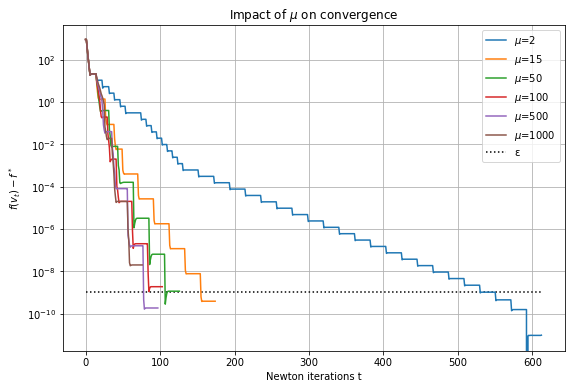

In [6]:
μ_values = [2, 15, 50, 100, 500, 1000]
f_vals_list, f_star_list = [], []
for μ in μ_values:
    print(f"computing barrier method for μ = {μ}")
    traj = barr_method(Q, p, A, b, v0, eps, μ)

    v_star = traj[-1]
    f_vals = dual(traj, Q, p)
    f_vals_list.append(f_vals)
    f_star_list.append(f_vals.min())
f_star = min(f_star_list)


plt.figure(figsize=(9,6))
for μ_id in range(len(μ_values)):
    plt.semilogy(f_vals_list[μ_id] - f_star, label=f"$\mu$={μ_values[μ_id]}")
plt.hlines(eps, 0, len(f_vals_list[0]), 'k', linestyles=':', label="ε")
plt.xlabel('Newton iterations t'), plt.ylabel('$f(v_t) - f^*$')
plt.title('Impact of $\mu$ on convergence'), plt.legend(), plt.grid()
plt.show()

* One can see the total number of Newton iterations is not very sensitive for $\mu \geq 15$. A right choice of $\mu$ seems to be in the order of $10^2$.  
* Knowing the dual optimizer $v^*$, we try to retrieve primal optimizer $w^*$.
We know from dual computation that these optimizers satisfy $$ v^* = z^* = Xw^* - y$$ and that $\forall i \in [\![1,d]\!] $
\begin{cases}
w^*_i > 0 &\text{if } X^\top v^* = -\lambda \\
w^*_i < 0 &\text{if } X^\top v^* = \lambda \\
w^*_i = 0 &\text{else } 
\end{cases}
which gives $\text{sign}(w^*)$. We then get 
$$w^* = (X \text{ diag} (\text{sign}(w^*))^+ (v^*+y)$$
eventually corected for right signs.

d(v*) =  894.6591988868961
p(w*) =  894.6591989068964


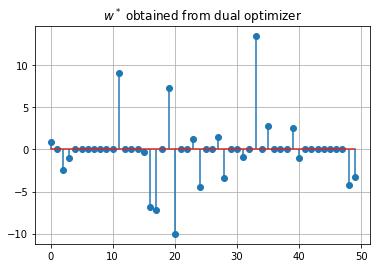

In [7]:
XTv = X.T @ v_star
sign_w = np.zeros(d)
sign_w[np.isclose(XTv, -λ)] = +1
sign_w[np.isclose(XTv, +λ)] = -1
w_star = np.linalg.pinv(X * sign_w) @ (v_star + y)
w_star[sign_w<0] = -np.abs(w_star[sign_w<0])
w_star[sign_w>0] = np.abs(w_star[sign_w>0])

print("d(v*) = ",-dual(v_star, Q, p))
print("p(w*) = ",primal(w_star, X, y, λ)) 

plt.stem(w_star), plt.grid(), plt.title("$w^*$ obtained from dual optimizer")
plt.show()